In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
all_out

[{'train_size': 10,
  'predictions': (#159) [1,1,1,1,1,1,1,1,1,1...],
  'xgboost': {'accuracy': 0.7547169811320755,
   'acc_macro': 0.7547169811320755,
   'racc': 0.7547169811320755,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.43010752688172044,
   'f1_micro': 0.7547169811320755,
   'frac_valid': 1.0,
   'all_y_true': (#159) [1,1,1,1,0,1,0,1,1,1...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1]),
   'valid_indices': [0

In [7]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost"]["accuracy"],
        "f1_macro": out["xgboost"]["f1_macro"],
        "f1_micro": out["xgboost"]["f1_micro"],
        "kappa": out["xgboost"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn"]["accuracy"],
        "f1_macro": out["tabpfn"]["f1_macro"],
        "f1_micro": out["tabpfn"]["f1_micro"],
        "kappa": out["tabpfn"]["kappa"],
    }


    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)


In [8]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [9]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [10]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [11]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [12]:
grouped_res.loc[:]

frac_valid                accuracy                f1_macro      \
                 mean std count sem      mean std count sem      mean std   
train_size                                                                  
10                1.0 NaN     1 NaN  0.754717 NaN     1 NaN  0.430108 NaN   

                      f1_micro               kappa                
           count sem      mean std count sem  mean std count sem  
train_size                                                        
10             1 NaN  0.754717 NaN     1 NaN   0.0 NaN     1 NaN

In [13]:
grouped_tabpfn_res

accuracy                f1_macro                f1_micro      \
                mean std count sem      mean std count sem      mean std   
train_size                                                                 
10          0.767296 NaN     1 NaN  0.502495 NaN     1 NaN  0.767296 NaN   

                         kappa                
           count sem      mean std count sem  
train_size                                    
10             1 NaN  0.098391 NaN     1 NaN

In [14]:
grouped_xgboost_res

accuracy                f1_macro                f1_micro      \
                mean std count sem      mean std count sem      mean std   
train_size                                                                 
10          0.754717 NaN     1 NaN  0.430108 NaN     1 NaN  0.754717 NaN   

                     kappa                
           count sem  mean std count sem  
train_size                                
10             1 NaN   0.0 NaN     1 NaN

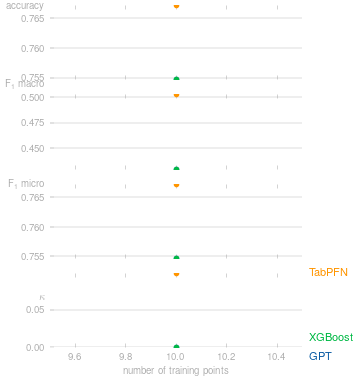

In [15]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
            grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[ :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[:][metric]["mean"]
            - grouped_xgboost_res.loc[ :][metric]["sem"],
            grouped_xgboost_res.loc[:][metric]["mean"]
            + grouped_xgboost_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[ :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[:][metric]["mean"]
            - grouped_tabpfn_res.loc[ :][metric]["sem"],
            grouped_tabpfn_res.loc[ :][metric]["mean"]
            + grouped_tabpfn_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    fig.savefig("mof_water_stability.pdf", bbox_inches="tight")

In [32]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

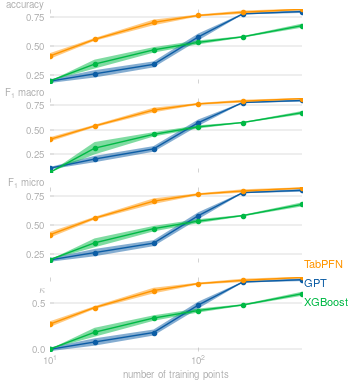

In [12]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, :].index,
            grouped_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[5, :].index,
            grouped_res.loc[5, :][metric]["mean"] - grouped_res.loc[5, :][metric]["sem"],
            grouped_res.loc[5, :][metric]["mean"] + grouped_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    ax[0].set_xscale("log")
    fig.savefig("polymner-classification_results_5.pdf", bbox_inches="tight")